### Set Up

In [1]:
# if you're running this cell in Kaggle Notebook, don't forget to turn on the internet of your notebook
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.9 MB/s eta 0:00:0000:0100:01


In [2]:
import pandas as pd
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from torch_geometric.nn import GINConv, Sequential, global_add_pool
from torch_geometric.data import Data, DataLoader

# Input Data

In [3]:
# Load the datasets
hr_df = pd.read_csv("/notebooks/hr_train.csv") # change the directory if needed
lr_df = pd.read_csv("/notebooks/lr_train.csv")

# Convert to numpy arrays
hr_data = hr_df.values
lr_data = lr_df.values

# Data Preprocessing

### Data Distirbution Visualization

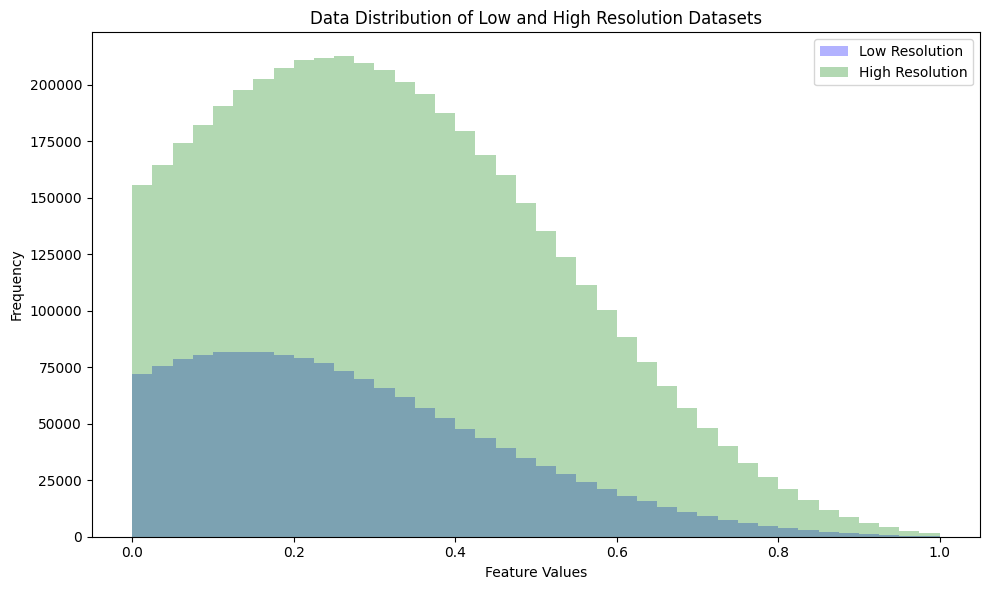

In [4]:
# Overlayed histograms for both datasets
plt.figure(figsize=(10, 6))

# Flatten the data to 1D for histogram plotting of non zero values
lr_flat = np.ravel(lr_data[lr_data != 0])
hr_flat = np.ravel(hr_data[hr_data != 0])

# Calculate the number of bins for the histogram
bins = np.histogram(np.hstack((lr_flat, hr_flat)), bins=40)[1] # get the bin edges

plt.hist(lr_flat, bins=bins, color='blue', alpha=0.3, label='Low Resolution', density=False)
plt.hist(hr_flat, bins=bins, color='green', alpha=0.3, label='High Resolution', density=False)

plt.title('Data Distribution of Low and High Resolution Datasets')
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Vectorization & Antivectorization

In [5]:
class MatrixVectorizer:
    """
    A class for transforming between matrices and vector representations.
    
    This class provides methods to convert a symmetric matrix into a vector (vectorize)
    and to reconstruct the matrix from its vector form (anti_vectorize), focusing on 
    vertical (column-based) traversal and handling of elements.
    """

    def __init__(self):
        """
        Initializes the MatrixVectorizer instance.
        
        The constructor currently does not perform any actions but is included for 
        potential future extensions where initialization parameters might be required.
        """
        pass

    @staticmethod
    def vectorize(matrix, include_diagonal=False):
        """
        Converts a matrix into a vector by vertically extracting elements.
        
        This method traverses the matrix column by column, collecting elements from the
        upper triangle, and optionally includes the diagonal elements immediately below
        the main diagonal based on the include_diagonal flag.
        
        Parameters:
        - matrix (numpy.ndarray): The matrix to be vectorized.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the vectorization.
          Defaults to False.
        
        Returns:
        - numpy.ndarray: The vectorized form of the matrix.
        """
        # Determine the size of the matrix based on its first dimension
        matrix_size = matrix.shape[0]

        # Initialize an empty list to accumulate vector elements
        vector_elements = []

        # Iterate over columns and then rows to collect the relevant elements
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:  
                    if row < col:
                        # Collect upper triangle elements
                        vector_elements.append(matrix[row, col])
                    elif include_diagonal and row == col + 1:
                        # Optionally include the diagonal elements immediately below the diagonal
                        vector_elements.append(matrix[row, col])

        return np.array(vector_elements)

    @staticmethod
    def anti_vectorize(vector, matrix_size, include_diagonal=False):
        """
        Reconstructs a matrix from its vector form, filling it vertically.
        
        The method fills the matrix by reflecting vector elements into the upper triangle
        and optionally including the diagonal elements based on the include_diagonal flag.
        
        Parameters:
        - vector (numpy.ndarray): The vector to be transformed into a matrix.
        - matrix_size (int): The size of the square matrix to be reconstructed.
        - include_diagonal (bool, optional): Flag to include diagonal elements in the reconstruction.
          Defaults to False.
        
        Returns:
        - numpy.ndarray: The reconstructed square matrix.
        """
        # Initialize a square matrix of zeros with the specified size
        matrix = np.zeros((matrix_size, matrix_size))

        # Index to keep track of the current position in the vector
        vector_idx = 0

        # Fill the matrix by iterating over columns and then rows
        for col in range(matrix_size):
            for row in range(matrix_size):
                # Skip diagonal elements if not including them
                if row != col:  
                    if row < col:
                        # Reflect vector elements into the upper triangle and its mirror in the lower triangle
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1
                    elif include_diagonal and row == col + 1:
                        # Optionally fill the diagonal elements after completing each column
                        matrix[row, col] = vector[vector_idx]
                        matrix[col, row] = vector[vector_idx]
                        vector_idx += 1

        return matrix

In [6]:
def load_data_as_graphs(df, matrix_size):
    graphs = []
    for index, row in df.iterrows():
        vector = row.values
        adjacency_matrix = MatrixVectorizer.anti_vectorize(vector, matrix_size)
        graph = Data(adjacency_matrix=np.array(adjacency_matrix))
        graphs.append(graph)
    return graphs

def get_matrix_size(num_features):
    return int(np.sqrt(num_features * 2)) + 1

### Split Data for Training, Testing, and Validation

In [7]:
# Determine the matrix size for low-resolution and high-resolution data
lr_matrix_size = get_matrix_size(lr_df.shape[1])
hr_matrix_size = get_matrix_size(hr_df.shape[1])

# Convert the dataframe to graph objects
lr_graphs = load_data_as_graphs(lr_df, lr_matrix_size)
hr_graphs = load_data_as_graphs(hr_df, hr_matrix_size)

# Split the data into training and test sets
lr_train, lr_test, hr_train, hr_test = train_test_split(
    lr_graphs, hr_graphs, test_size=0.2, random_state=42
)

In [8]:
print("LR Train Set samples: ",len(lr_train))
print("LR Test Set samples: ",len(lr_test))

print("HR Train Set samples: ",len(hr_train))
print("HR Test Set samples: ",len(lr_test))

LR Train Set samples:  133
LR Test Set samples:  34
HR Train Set samples:  133
HR Test Set samples:  34


In [9]:
# convert list to tensor
lr_train_array = np.random.normal(0.5, 1,(len(lr_train), 160, 160))
hr_train_array = np.random.normal(0.5, 1,(len(hr_train), 268, 268))
lr_test_array = np.random.normal(0.5, 1,(len(lr_test), 160, 160))
hr_test_array = np.random.normal(0.5, 1,(len(hr_test), 268, 268))
i = 0

for lr, hr in zip(lr_train, hr_train):
    lr_train_array[i] = lr.adjacency_matrix
    hr_train_array[i] = hr.adjacency_matrix
    i +=1

j = 0
for lr, hr in zip(lr_test, hr_test):
    lr_test_array[j] = lr.adjacency_matrix
    hr_test_array[j] = hr.adjacency_matrix
    i +=1

print(lr_train_array.shape)
print(lr_test_array.shape)

(133, 160, 160)
(34, 160, 160)


# AGSR Model

### Model Definition

In [14]:
## Helper Functions
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def weight_variable_glorot(output_dim):
    input_dim = output_dim
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = np.random.uniform(-init_range, init_range,(input_dim, output_dim))
    return initial

def normalize_adj_torch(mx):
    rowsum = mx.sum(1)
    r_inv_sqrt = torch.pow(rowsum, -0.5).flatten()
    r_inv_sqrt[torch.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = torch.diag(r_inv_sqrt)
    mx = torch.matmul(mx, r_mat_inv_sqrt)
    mx = torch.transpose(mx, 0, 1)
    mx = torch.matmul(mx,  r_mat_inv_sqrt)
    return mx

In [15]:
class GraphUnpool(nn.Module):
    def __init__(self):
        super(GraphUnpool, self).__init__()

    def forward(self, A, X, idx):
        new_X = torch.zeros([A.shape[0], X.shape[1]]).to(device)
        new_X[idx] = X
        return A, new_X

    
class GraphPool(nn.Module):
    def __init__(self, k, in_dim):
        super(GraphPool, self).__init__()
        self.k = k
        self.proj = nn.Linear(in_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, A, X):
        scores = self.proj(X)
        # scores = torch.abs(scores)
        scores = torch.squeeze(scores)
        scores = self.sigmoid(scores/100)
        num_nodes = A.shape[0]
        values, idx = torch.topk(scores, int(self.k*num_nodes))
        new_X = X[idx, :]
        values = torch.unsqueeze(values, -1)
        new_X = torch.mul(new_X, values)
        A = A[idx, :]
        A = A[:, idx]
        return A, new_X, idx


class GCN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.drop = nn.Dropout(p=0)

    def forward(self, A, X):
        X = self.drop(X)
        # X = torch.matmul(A, X)
        X = self.proj(X)
        return X
    

class GraphUnet(nn.Module):
    def __init__(self, ks, in_dim, out_dim, dim=268):
        super(GraphUnet, self).__init__()
        self.ks = ks
        self.start_gcn = GCN(in_dim, dim).to(device)
        self.bottom_gcn = GCN(dim, dim).to(device)
        self.end_gcn = GCN(2*dim, out_dim).to(device)
        self.down_gcns = []
        self.up_gcns = []
        self.pools = []
        self.unpools = []
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gcns.append(GCN(dim, dim).to(device))
            self.up_gcns.append(GCN(dim, dim).to(device))
            self.pools.append(GraphPool(ks[i], dim).to(device))
            self.unpools.append(GraphUnpool().to(device))

    def forward(self, A, X):
        adj_ms = []
        indices_list = []
        down_outs = []
        X = self.start_gcn(A, X)
        start_gcn_outs = X
        org_X = X
        for i in range(self.l_n):
            X = self.down_gcns[i](A, X)
            adj_ms.append(A)
            down_outs.append(X)
            A, X, idx = self.pools[i](A, X)
            indices_list.append(idx)
        
        X = self.bottom_gcn(A, X)
        
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            A, idx = adj_ms[up_idx], indices_list[up_idx]
            A, X = self.unpools[i](A, X, idx)
            X = self.up_gcns[i](A, X)
            X = X.add(down_outs[up_idx])
        X = torch.cat([X, org_X], 1)
        X = self.end_gcn(A, X)
        
        return X, start_gcn_outs


class GSRLayer(nn.Module):
    def __init__(self,hr_dim):
        super(GSRLayer, self).__init__()
        
        self.hr_dim = hr_dim
        self.weights = torch.from_numpy(weight_variable_glorot(hr_dim)).type(torch.FloatTensor).to(device)
        self.weights = torch.nn.Parameter(data=self.weights, requires_grad = True).to(device)

    def forward(self,A,X):
        lr = A
        lr_dim = lr.shape[0]
        hr_dim = self.hr_dim
        f = X
        #eig_val_lr, U_lr = torch.symeig(lr, eigenvectors=True,upper=True)
        eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO='U')
        # U_lr = torch.abs(U_lr)
        eye_mat = torch.eye(lr_dim).type(torch.FloatTensor).to(device)
        # s_d = torch.cat((eye_mat,eye_mat),0)
        s_d = torch.cat((eye_mat, torch.ones(hr_dim - lr_dim, lr_dim).to(device)), dim=0)
        a = torch.matmul(self.weights,s_d)
        b = torch.matmul(a ,torch.t(U_lr))
        f_d = torch.matmul(b ,f)
        f_d = torch.abs(f_d)
        self.f_d = f_d.fill_diagonal_(1)
        adj = normalize_adj_torch(self.f_d)
        X = torch.mm(adj, adj.t())
        X = (X + X.t())/2
        idx = torch.eye(268, dtype=bool)
        X[idx]=1
        return adj, torch.abs(X)
    

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, dropout=0., act=F.relu):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.act = act
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)

    def forward(self, input, adj):
        # input = F.dropout(input, self.dropout, self.training)
        support = torch.mm(input, self.weight)
        output = torch.mm(adj, support)
        # output = self.act(output)
        return output
    
    
    
class GSRNet(nn.Module):
    def __init__(self,ks,args):
        super(GSRNet, self).__init__()

        self.lr_dim = args.lr_dim
        self.hr_dim = args.hr_dim
        self.hidden_dim = args.hidden_dim
        self.layer = GSRLayer(self.hr_dim).to(device)
        self.net = GraphUnet(ks, self.lr_dim, self.hr_dim).to(device)
        self.gc1 = GraphConvolution(self.hr_dim, self.hidden_dim, 0, act=F.relu).to(device)
        self.gc2 = GraphConvolution(self.hidden_dim, self.hr_dim, 0, act=F.relu).to(device)

    def forward(self,lr):
        I = torch.eye(self.lr_dim).type(torch.FloatTensor).to(device)
        A = normalize_adj_torch(lr).type(torch.FloatTensor).to(device)

        self.net_outs, self.start_gcn_outs = self.net(A, I)
        self.outputs, self.Z = self.layer(A, self.net_outs)

        self.hidden1 = self.gc1(self.Z, self.outputs)
        self.hidden2 = self.gc2(self.hidden1, self.outputs)

        z = self.hidden2
        z = (z + z.t())/2
        idx = torch.eye(self.hr_dim, dtype=bool) 
        z[idx]=1

        return torch.abs(z), self.net_outs, self.start_gcn_outs, self.outputs

### Model Training

In [16]:
# Set a fixed random seed for reproducibility across multiple libraries
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


criterion = nn.MSELoss()
criterion.to(device)

def check_model_device(model):
    for name, param in model.named_parameters():
        print(f"Parameter {name} is stored on {param.device}")
        
def train(model, optimizer, subjects_adj, subjects_labels, args):
    i = 0
    all_epochs_loss = []
    no_epochs = args.epochs

    for epoch in range(no_epochs):
        epoch_loss = []
        epoch_error = []
        
        for lr,hr in zip(subjects_adj,subjects_labels):
            model.train()
            optimizer.zero_grad()       
            lr = torch.from_numpy(lr).type(torch.FloatTensor).to(device)
            hr = torch.from_numpy(hr).type(torch.FloatTensor).to(device)  
            model_outputs, net_outs, start_gcn_outs, layer_outs = model(lr)
            hr_p = hr.cpu()
            eig_val_hr, U_hr = torch.linalg.eigh(hr_p.to(device), UPLO='U')

            # loss function
            loss = args.lmbda * criterion(net_outs, start_gcn_outs) + criterion(model.layer.weights,U_hr) + criterion(model_outputs, hr) 
            error = criterion(model_outputs, hr)
            
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            epoch_error.append(error.item())
      
        i+=1
        print("Epoch: ",i, "Loss: ", np.mean(epoch_loss), "Error: ", np.mean(epoch_error)*100,"%")
        all_epochs_loss.append(np.mean(epoch_loss))

    # plot loss 
    plt.plot(all_epochs_loss)
    plt.title('GSR-UNet with self reconstruction: Loss')
    plt.show(block=False)
 

In [25]:
class Args:
    def __init__(self):
        self.epochs = 3
        self.lr = 0.0001
        self.splits = 5
        self.lmbda = 16
        self.lr_dim = 160
        self.hr_dim = 268
        self.hidden_dim = 320

args = Args()

ks = [0.9, 0.7, 0.6, 0.5]
model = GSRNet(ks, args) 
optimizer = optim.AdamW(model.parameters(), lr=args.lr)

def count_parameters(model_check):
    return sum(p.numel() for p in model_check.parameters() if p.requires_grad)
print(model)
model_params = count_parameters(model)
print(f"Model Parameters: {model_params}")

GSRNet(
  (layer): GSRLayer()
  (net): GraphUnet(
    (start_gcn): GCN(
      (proj): Linear(in_features=160, out_features=268, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (bottom_gcn): GCN(
      (proj): Linear(in_features=268, out_features=268, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
    (end_gcn): GCN(
      (proj): Linear(in_features=536, out_features=268, bias=True)
      (drop): Dropout(p=0, inplace=False)
    )
  )
  (gc1): GraphConvolution()
  (gc2): GraphConvolution()
)
Model Parameters: 502500


Epoch:  1 Loss:  0.1310315313083785 Error:  8.33078148893844 %
Epoch:  2 Loss:  0.09670315962985046 Error:  6.678386581571479 %
Epoch:  3 Loss:  0.08634856152803377 Error:  6.21360828609843 %


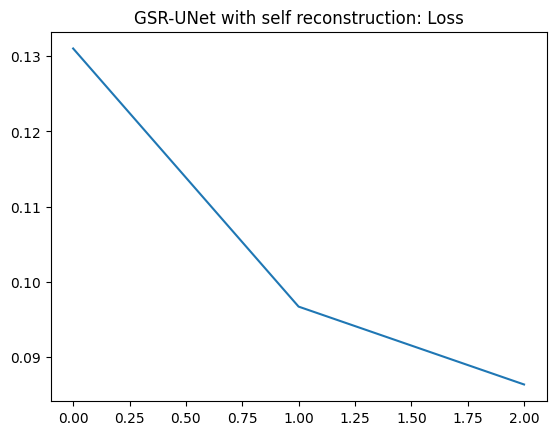

In [26]:
train(model, optimizer, lr_train_array, hr_train_array, args)

# Evaluation

In [48]:
!pip install tqdm

In [61]:
from multiprocessing import Pool
import numpy as np
import networkx as nx
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import tqdm

def compute_centralities(args):
    pred_matrix, gt_matrix = args
    pred_graph = nx.from_numpy_array(pred_matrix)
    gt_graph = nx.from_numpy_array(gt_matrix)

    # Compute centrality measures
    pred_bc = list(nx.betweenness_centrality(pred_graph, weight='weight').values())
    pred_ec = list(nx.eigenvector_centrality(pred_graph, weight='weight').values())
    pred_pc = list(nx.pagerank(pred_graph, weight='weight').values())

    gt_bc = list(nx.betweenness_centrality(gt_graph, weight='weight').values())
    gt_ec = list(nx.eigenvector_centrality(gt_graph, weight='weight').values())
    gt_pc = list(nx.pagerank(gt_graph, weight='weight').values())

    return pred_bc, pred_ec, pred_pc, gt_bc, gt_ec, gt_pc

def evaluation_parallel(pred_matrices, gt_matrices, num_test_samples, fold=1):
    # pool = Pool(processes=4)  # Use Pool() without arguments to use as many processes as there are CPUs
    # centrality_results = pool.map(compute_centralities, [(pred_matrices[i], gt_matrices[i]) for i in range(num_test_samples)])
    with Pool(processes=4) as pool:
        # Create an iterator to compute centralities in parallel and track progress
        tasks1 = [(pred_matrices[i], gt_matrices[i]) for i in range(num_test_samples)]
        results_iter1 = pool.imap_unordered(compute_centralities, tasks1)
        
        # Initialize progress bar
        pbar = tqdm.tqdm(total=num_test_samples, desc='Evaluating')

        centrality_results = []
        for result in results_iter1:
            centrality_results.append(result)
            pbar.update()  

        pbar.close()  
        mae_bc, mae_ec, mae_pc = [], [], []
        for result in centrality_results:
            pred_bc, pred_ec, pred_pc, gt_bc, gt_ec, gt_pc = result
            mae_bc.append(mean_absolute_error(pred_bc, gt_bc))
            mae_ec.append(mean_absolute_error(pred_ec, gt_ec))
            mae_pc.append(mean_absolute_error(pred_pc, gt_pc))
        
 
    pred_1d_list = []
    gt_1d_list = []

    for i in range(num_test_samples):
        # Vectorize matrices
        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(gt_matrices[i]))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    bar = np.array([mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc])
    x = np.array(['MAE','PCC','JSD','MAE(BC)','MAE(EC)','MAE(PC)'])
    y = np.arange(len(bar))
    plt.bar(y,bar)

    for a, b in zip(y,bar):
        plt.text(a,b,('%.2f'%b),verticalalignment='bottom',horizontalalignment='right')

    plt.xticks(y,x)
    plt.title('Fold {}'.format(fold))
    plt.show()

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)
    
    return 

Evaluating: 100%|██████████| 34/34 [29:46<00:00, 52.54s/it]


In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx
 
def evaluation(pred_matrices, gt_matrices, num_test_samples, fold=1):
    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []
    pred_1d_list = []
    gt_1d_list = []
    
    # Iterate over each test sample
    for i in range(num_test_samples):
        # # Convert adjacency matrices to NetworkX graphs
        # pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
        # gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")

        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i])
        gt_graph = nx.from_numpy_array(gt_matrices[i])
        
        # Add edge attributes
        for edge in pred_graph.edges():
            pred_graph.edges[edge]['weight'] = pred_matrices[i][edge]
        
        for edge in gt_graph.edges():
            gt_graph.edges[edge]['weight'] = gt_matrices[i][edge]
 
        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")
 
        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")
 
        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())
 
        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())
 
        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))
 
        # Vectorize matrices
        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(gt_matrices[i]))
 
    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)
 
    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)
 
    # Compute metrics
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)
 
    bar = np.array([mae,pcc,js_dis,avg_mae_bc,avg_mae_ec,avg_mae_pc])
    x = np.array(['MAE','PCC','JSD','MAE(BC)','MAE(EC)','MAE(PC)'])
    y = np.arange(len(bar))
    plt.bar(y,bar)
 
    for a, b in zip(y,bar):
        plt.text(a,b,('%.2f'%b),verticalalignment='bottom',horizontalalignment='right')
 
    plt.xticks(y,x)
    plt.title('Fold {}'.format(fold))
    plt.show()
 
    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)
    
    return 

In [62]:
def test(model, test_adj, test_labels, args, fold=1):
    test_error = []
    preds_list=[]
    g_t = []
    num_test_samples = test_adj.shape[0]
    num_roi = 268
    pred_matrices = torch.randn(num_test_samples, num_roi, num_roi).numpy()
    gt_matrices = torch.randn(num_test_samples, num_roi, num_roi).numpy()

    i=0
    with torch.no_grad():
        for lr, hr in zip(test_adj,test_labels):

            all_zeros_lr = not np.any(lr)
            all_zeros_hr = not np.any(hr)

            if all_zeros_lr == False and all_zeros_hr==False:
                lr = torch.from_numpy(lr).type(torch.FloatTensor).to(device)
                np.fill_diagonal(hr,1)
                hr = torch.from_numpy(hr).type(torch.FloatTensor).to(device)
                preds,a,b,c = model(lr)

                preds_list.append(preds.flatten().detach().cpu().clone().numpy())
                error = criterion(preds, hr)
                g_t.append(hr.flatten())
                test_error.append(error.item())

                pred_matrices[i] = preds.detach().cpu().clone().numpy()
                gt_matrices[i]   = hr.detach().cpu().clone().numpy()
                i += 1
            
    print ("Test error MSE: ", np.mean(test_error))
    evaluation_parallel(pred_matrices, gt_matrices, num_test_samples, fold)
    

Test error MSE:  1.0643031474422007


Evaluating: 100%|██████████| 34/34 [08:04<00:00, 14.24s/it]


Data 0 from 34 has been processed
Data 1 from 34 has been processed
Data 2 from 34 has been processed
Data 3 from 34 has been processed
Data 4 from 34 has been processed
Data 5 from 34 has been processed
Data 6 from 34 has been processed
Data 7 from 34 has been processed
Data 8 from 34 has been processed
Data 9 from 34 has been processed
Data 10 from 34 has been processed
Data 11 from 34 has been processed
Data 12 from 34 has been processed
Data 13 from 34 has been processed
Data 14 from 34 has been processed
Data 15 from 34 has been processed
Data 16 from 34 has been processed
Data 17 from 34 has been processed
Data 18 from 34 has been processed
Data 19 from 34 has been processed
Data 20 from 34 has been processed
Data 21 from 34 has been processed
Data 22 from 34 has been processed
Data 23 from 34 has been processed
Data 24 from 34 has been processed
Data 25 from 34 has been processed
Data 26 from 34 has been processed
Data 27 from 34 has been processed
Data 28 from 34 has been proce

posx and posy should be finite values
posx and posy should be finite values


MAE:0.8176053166389465 |PCC: -0.0006813808030088002 |JSD: inf |MAE(BC): 0.4801462364516316 |MAE(EC): 0.01490417839537023 |MAE(PC): 0.0008761054542997177


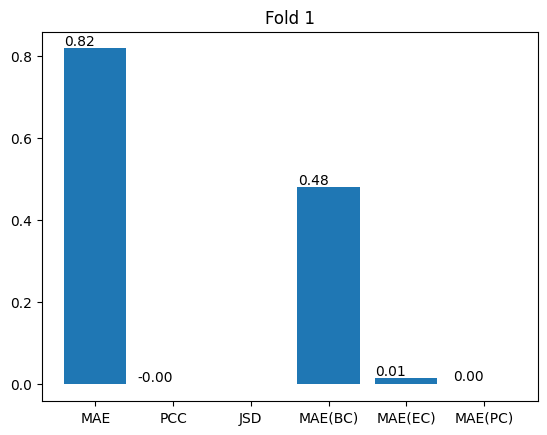

MAE:  0.8176053
PCC:  -0.0006813808030088002
Jensen-Shannon Distance:  inf
Average MAE betweenness centrality: 0.4801462364516316
Average MAE eigenvector centrality: 0.01490417839537023
Average MAE PageRank centrality: 0.0008761054542997177


In [63]:
test(model, lr_test_array, hr_test_array, args)

### 3-Fold Cross Validation

In [40]:
# SIMULATING THE DATA: 
# 3-fold
cv = KFold(n_splits=3, random_state=42, shuffle=True)
fold = 0
model.to(device)
for train_index, test_index in cv.split(lr_train_array):
    fold +=1
    print(f"Fold {fold}")
    
    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = lr_train_array[
        train_index], lr_train_array[test_index], hr_train_array[train_index], hr_train_array[test_index]
    
    train(model, optimizer, subjects_adj, subjects_ground_truth, args)
    test(model, test_adj, test_ground_truth, args, fold)
    print("\n")

Fold 1 

Epoch:  1 Loss:  0.07279550436545502 Error:  5.70101029747589 %
Epoch:  2 Loss:  0.07084523196416823 Error:  5.61823648061942 %
Epoch:  3 Loss:  0.06925042396919294 Error:  5.554700448093089 %
Test error MSE:  0.05758916272057427
Fold 2 

Epoch:  1 Loss:  0.07156390453992265 Error:  5.860345224651058 %
Epoch:  2 Loss:  0.06951333938187428 Error:  5.721346221947938 %
Epoch:  3 Loss:  0.06791278359930167 Error:  5.620349077193924 %
Test error MSE:  0.05230081259188327
Fold 3 

Epoch:  1 Loss:  0.06745754345581773 Error:  5.6230809037270175 %
Epoch:  2 Loss:  0.06608087644818124 Error:  5.529854672678401 %
Epoch:  3 Loss:  0.064962621401535 Error:  5.45876155910867 %
Test error MSE:  0.05128070432692766


# Visualization

torch.Size([216])


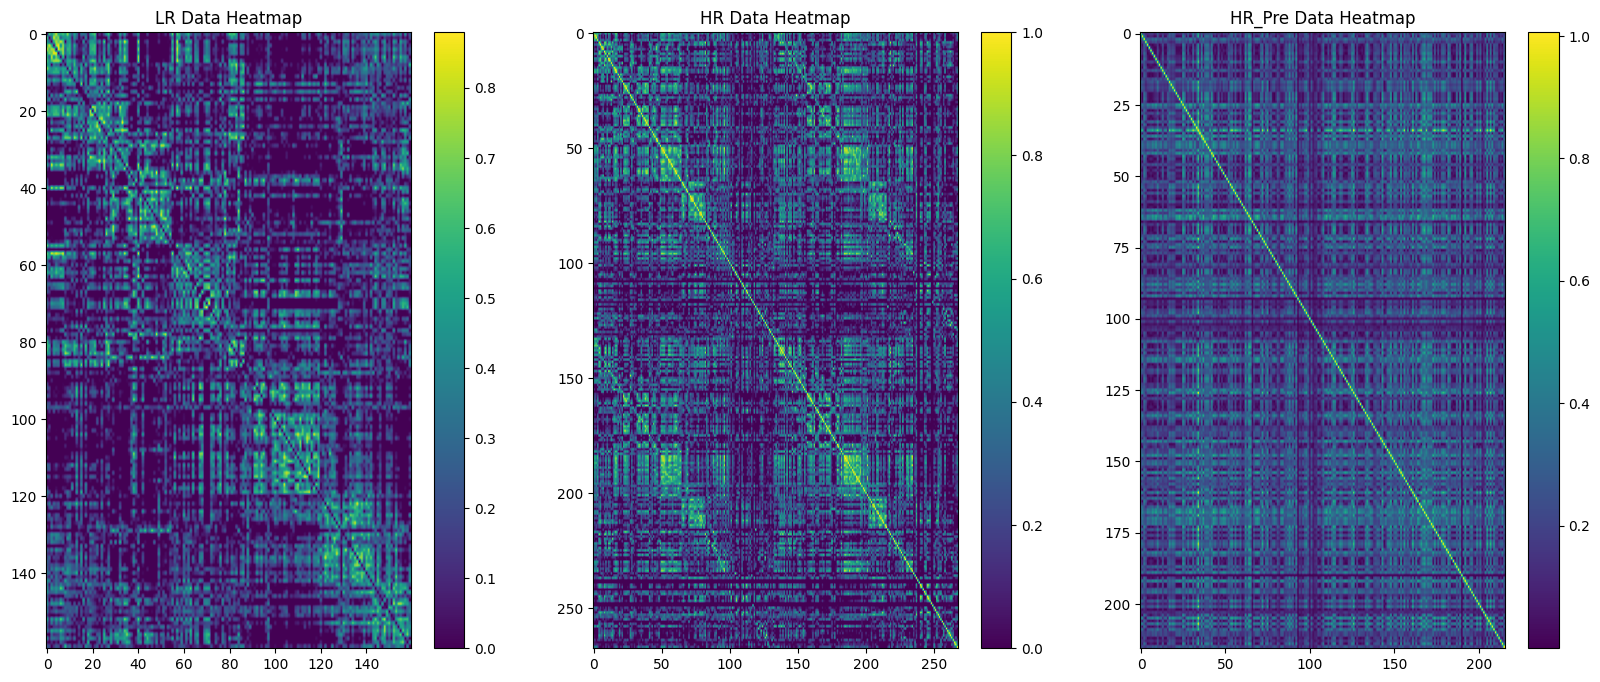

In [35]:
lr_test_array, hr_test_array
lr = lr_test_array[0, :]
hr = hr_test_array[0, :]
lr = torch.from_numpy(lr).type(torch.FloatTensor)
np.fill_diagonal(hr, 1)

preds, a, b, c = model(lr)
print(preds[0].shape)

plt.figure(figsize=(20, 8))
 
# Heatmap of a subset of LR data
plt.subplot(1, 3, 1)
plt.imshow(lr, aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('LR Data Heatmap')
 
# Heatmap of a subset of HR data
plt.subplot(1, 3, 2)
plt.imshow(hr, aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('HR Data Heatmap')
 
# Heatmap of a subset of HR data
plt.subplot(1, 3, 3)
plt.imshow(preds.detach().cpu().clone().numpy() , aspect='auto', cmap='viridis')  # Adjust subset size as needed
plt.colorbar()
plt.title('HR_Pre Data Heatmap')
 
plt.show()

# Output Processing Evaluation

In [ ]:
lrt_df = pd.read_csv("/kaggle/input/dgl-icl/lr_test.csv")

lrt_matrix_size = get_matrix_size(lrt_df.shape[1])
lrt_graphs = load_data_as_graphs(lrt_df, lrt_matrix_size)
lrt_array = np.random.normal(0.5, 1,(len(lrt_graphs), 160, 160))

i = 0
for lrt in lrt_graphs:
    lrt_array[i] = lrt.adjacency_matrix
    i +=1

print(lrt_array.shape)

In [ ]:
def submission(model,data_array, vector_dim=35778):
    n_samples = data_array.shape[0]

    results_array = np.zeros((n_samples, vector_dim))
    results_array.shape

    i = 0
    for lr in data_array:
        lr_tensor = torch.from_numpy(lr).type(torch.FloatTensor)

        with torch.no_grad():  
            preds, _, _, _ = model(lr_tensor)  

        prediction = preds.detach().cpu().numpy()
        vectorized_pred = MatrixVectorizer.vectorize(prediction) 

        results_array[i, :] = vectorized_pred
        i += 1

    print(results_array.shape)
    
    melted_result = results_array.flatten()
    ids = np.arange(1, melted_result.shape[0]+1)
    print(ids.shape)
    print(melted_result.shape)
    df = pd.DataFrame({
        "ID": ids,
        "Predicted": melted_result
    })

    print(df.shape)
    print(df.head())
    df.to_csv("/kaggle/working/submission.csv", index=False)
    print("the results are saved")
    return 

submission(model, lrt_array)